In [2]:
#this program takes the dushinsky matrix and displacement vector as input
#calculates the covariance matrix and displacement vector after the transformation given by the dushinsky matrix
#calculates the reduced covariance and displacement for given modes (spins)
#calculates the statistics of photons for given modes (spins)
#uses matching pursuit with brute force argmax maximization (only pairs of modes)
#or matching pursuit with Ising for nn modes, not necessary 2 nn
#finds the joint distribution
#expresses it in terms of energies



import matplotlib.pyplot as plt
import numpy as np
import wojciech_remastered as wo

import numpy as np
from qiskit.quantum_info.operators.symplectic import SparsePauliOp
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from bitstring import BitArray
from collections import Counter
import copy

In [3]:
N = 2 # dimensionality of a mode (cutoff)
M = 26
nn = 2 #number of nearest neigbhors
boundary = 0  #number of spins at the boundary 0 < boundary < nn

In [4]:
U = np.array([[-5.92589065E-02, -9.98224695E-01, 3.00864905E-04,  9.07098304E-04, -1.22872283E-03, -4.36578346E-03, -2.27795095E-03, -2.02807363E-04, -9.37049357E-04, -8.97164548E-04, -1.37954017E-04,  6.36281397E-04, 1.33579978E-03, -5.93011159E-04, -6.70569269E-04,  3.43000240E-04, -1.05622948E-03, -1.03261221E-03, -3.03658627E-04, -1.05271873E-03,  3.34644813E-04,  5.67750173E-04, -5.74129048E-04,  1.11938046E-04,  1.49690876E-04,  5.12568571E-05], 
[9.97604955E-01, -5.93355600E-02, -2.91695562E-03, -2.94073445E-03,  4.22230603E-03,  1.08586653E-02, -1.35420271E-03, 2.74435499E-04,  1.56170546E-02,  2.17019802E-02, -1.75190924E-03,  7.88988914E-03, -1.08809110E-02,  4.83858213E-03,  1.33056546E-03, -1.07961095E-02,  4.02769119E-03, 4.90026752E-03,  1.08809613E-03,  6.22665907E-04,  1.32312504E-03, -2.39126169E-03, -3.86664325E-03,  1.04865475E-03,  9.08949461E-04, -6.60032252E-04],
[-2.97578091E-03, -1.21254892E-04, -9.99767677E-01,  9.48432740E-03,  1.75081419E-03,  3.92091553E-04, -3.68167326E-04, 1.17432292E-02,  6.30037671E-03,  3.10391764E-03, -1.30244451E-04, -6.24522703E-03, 4.56359553E-04, -7.21738535E-03,  4.08612362E-03, -2.40833729E-03, -4.04284603E-03, -4.75556391E-03, -2.78191488E-03, -2.63537923E-03, -1.41495764E-03, -5.73395996E-05, 1.53373547E-03,  8.59345314E-04,  2.22449433E-04,  5.58467628E-04], 
[-1.78960503E-03, -4.52301710E-04, -9.60036425E-03, -9.64342155E-01, -2.63124914E-01, -1.46450122E-04,  1.65800627E-03, -1.45772288E-03,  1.20803695E-02, -1.03234180E-02, -1.92891062E-02,  7.57285091E-06, 2.78349618E-04,  2.39582642E-03, -1.72356585E-04,  7.02481528E-04, -6.08806767E-04, 5.81653421E-03, -3.66202064E-03, -2.57948306E-03,  4.09846904E-06,  2.76245312E-03, 6.37221369E-04, -4.44579885E-04,  6.79836048E-04,  3.77891720E-03], 
[-4.97773983E-03, -1.13872301E-03, -7.63709794E-04, -2.62968533E-01,  9.64420435E-01,  1.45202580E-03, -1.19962364E-03, 3.20269844E-04,  9.95397376E-03, -9.27278493E-03, -3.12836431E-03,  2.72893678E-03, 8.27100858E-04,  6.58839207E-03,  8.63545736E-03, -3.10541577E-03,  6.71449641E-03, -1.43346597E-02,  7.20909690E-03,  2.02311868E-04,  3.09960899E-03, -4.15955756E-03, -1.16100483E-03, -1.42046990E-03, -6.01745674E-04, -6.56666836E-03],
[-7.62480519E-03, -3.76951189E-03, -1.56770402E-03,  4.38065786E-05, -6.14672459E-04,  9.61483915E-01,  8.98380243E-02, -2.57734792E-02, -9.80600187E-02, -1.28606384E-01,  8.63121057E-03,  8.91391608E-02, -1.25534952E-01, -6.93410658E-02, -8.54177875E-02,  2.54077237E-02,  2.47111753E-02, 6.75116510E-03,  2.88778254E-02, -3.49787944E-02, -3.53043947E-03,  1.29445163E-03, 2.04269671E-02,  1.57508188E-02, -2.41283156E-02, -2.57867379E-03],
[1.62765706E-03, -1.88346517E-03, 1.00309032E-03,  9.39455806E-04,  1.61153532E-03, -9.31443564E-02,  9.74897094E-01, 1.44306719E-01, -3.11966839E-02, -9.15867897E-04, -5.42643355E-03,  9.58453775E-02, -2.30183697E-02,  1.62485081E-02,  5.40014966E-02, -2.11540268E-02, -4.12210904E-02, -7.98411855E-03, -4.59697197E-02,  1.57630652E-03, -3.51557874E-02,  3.74426246E-03, -4.39019240E-03, -2.06115973E-02, -7.86411656E-03,  8.29373234E-03],
[1.06711997E-02,  1.57717293E-04, -1.59295076E-02,  2.18043688E-03,  3.91098577E-04, -9.86719301E-02,  9.70842622E-02, -8.06831839E-01, -3.23909369E-01, -3.22594897E-01, -7.86358766E-03,  6.83021600E-02, 3.22701745E-02,  2.83425036E-01, -1.06933188E-01, -7.20736240E-02,  9.06071223E-02, 6.59742752E-02, -3.88987833E-02, -1.36771604E-02,  5.09664304E-02, -4.13642572E-03, 1.83612570E-02, -1.30947709E-02, -1.80745159E-02, -5.97285354E-03],
[2.52680857E-02,  1.78281964E-04, 5.78502056E-04, -4.67732359E-03,  1.23953791E-04, -9.91136369E-02, -7.50795292E-02, 4.68192248E-01, -5.91175081E-01, -5.87547072E-01,  1.15067456E-01, -1.36984245E-01, 1.34539392E-01, -6.06986125E-02, -7.98702010E-02, -6.18351672E-02,  5.20049803E-02, -2.27203050E-02, -1.15090632E-02,  4.28377866E-02,  1.69578558E-02,  1.95459689E-02, -4.16540338E-03, -6.72183753E-03, -8.12552979E-03, -4.72793647E-03],
[5.95438949E-03, -3.59367081E-04, 3.49076137E-03,  2.52559530E-02, -4.16313975E-03, -2.08314882E-02,  2.74648084E-02, -1.23657258E-02,  5.14389428E-01, -6.11929506E-01, -5.44559779E-01, -1.97898015E-01, -8.08592568E-02, -9.41792127E-02,  6.35654921E-02,  3.00793812E-02, -2.29490666E-02, 4.09940627E-02, -2.30250591E-02, -8.49672225E-03,  6.39787513E-03,  6.36618704E-03, 8.15030848E-04, -1.02120712E-03,  9.92707126E-04, -1.01743873E-03],
[-2.24193204E-03, -1.28097794E-03, 2.29831874E-03, -5.84229558E-03,  1.14963460E-03, -2.57975260E-02,  4.19714676E-02, -2.87597679E-02, -4.92390735E-02,  3.29697525E-02,  2.37070544E-01, -6.40685642E-01, -7.06631189E-01,  1.54201067E-01,  4.11097884E-02,  2.38922476E-02, -2.91460237E-02, -1.68984276E-02, -2.19950742E-03, -5.04335972E-03, -1.07051239E-02,  2.26901487E-03, 1.93141184E-03,  6.16755005E-03, -3.00813648E-03, -4.08408574E-03], 
[-7.11243486E-03,  4.74924903E-04, -3.10497514E-03,  6.47693402E-03,  1.86265964E-03, -2.76769737E-02, -7.97762635E-02, 1.72468025E-01, -3.69995084E-01,  2.27750022E-01, -7.04585026E-01,  2.21843946E-01, -3.38918710E-01,  3.29224645E-01,  3.39611659E-03, -1.24675615E-02, -8.72609233E-03, -6.27567092E-02,  9.32516768E-03,  2.94046259E-02,  3.63313595E-03,  4.72102853E-03, -4.40942196E-03,  2.72636797E-03,  7.53372758E-03,  7.80109421E-03], 
[-3.00091951E-03,  8.91751038E-04, -2.16897909E-03, -7.30099381E-04, -6.45966984E-03, -1.24217125E-01, -1.05243452E-01, 3.11917277E-02,  1.01520123E-01, -2.87301348E-01,  3.03443336E-01,  6.53827590E-01, -5.09095443E-01, -7.47829824E-02,  2.67524119E-01,  5.88582341E-02, -8.83587465E-02, -7.18442417E-02, -4.89105570E-02,  3.30069783E-02,  5.71838740E-02, -5.66475346E-03, -9.40072251E-03, -1.30090257E-02,  8.49822228E-03, -4.48310968E-04], 
[5.24166066E-03,  3.60681732E-04, 2.81166347E-03, -4.79323435E-03,  7.55417797E-03, -7.95328997E-02,  2.75623431E-02, -2.41223261E-01, -2.97891219E-01,  1.34561746E-01, -2.10200064E-01, -7.07748191E-02, -1.44675643E-01, -8.54476639E-01,  1.40815271E-01,  6.96703217E-03,  3.44114866E-02, -1.03082435E-02, -6.34890296E-02,  1.66962233E-02,  4.27063993E-02, -8.71195571E-03, 6.49156257E-03,  9.12507608E-04, -2.13652884E-03, -4.27139935E-04], 
[-1.05797872E-02,  6.67709994E-04, -6.58602810E-04, -4.29043785E-05,  4.55615504E-03, -7.72794471E-02,  3.74744574E-03, 6.86964091E-02,  1.60414076E-01,  2.63732025E-02,  2.26656210E-02,  1.27324471E-01, -2.18637168E-01, -1.40830057E-01, -7.17462478E-01, -5.23273764E-01,  2.19865726E-01, 5.10793349E-02, -1.73435734E-01,  7.14405757E-02,  5.21846273E-02,  2.67173292E-02, -2.35345551E-04, -1.39407355E-02, -6.69471080E-03, -9.42066582E-03], 
[-1.08314146E-02, -4.52654692E-04, 3.54463455E-03,  1.61083605E-03, -8.79756568E-03,  8.29824560E-02, -2.43285199E-02, 6.18669465E-03,  9.14259767E-03,  1.58029242E-02, -9.54431184E-04, -5.31048425E-02, 5.58818015E-02,  6.14907969E-02,  5.45420494E-01, -8.09021382E-01,  1.08242524E-01, 2.52858974E-02,  1.17893425E-01, -6.08898709E-02,  1.54176943E-03, -1.20388360E-02, 9.39849660E-04,  6.13740842E-03, -6.72494809E-03,  1.02139738E-03], 
[-3.37379793E-03, -9.97222407E-04, -3.01060836E-03,  2.03469287E-03, -7.00917999E-03, -5.74659115E-03,  2.33219292E-02, 5.85720799E-02,  5.31913151E-02,  2.19675131E-02,  1.22741716E-02,  1.24740773E-02, -2.32944863E-02,  4.45981699E-02,  1.66924380E-01,  2.28384524E-01,  9.50065613E-01, -6.46549593E-04, -7.47590582E-02,  2.20040364E-02,  2.99727312E-02, -3.47881417E-03, -2.36600013E-03, -1.01761968E-02, -2.78951496E-03, -1.60340182E-04], 
[5.31789529E-03,  8.11418049E-04, 4.28337371E-03, -5.08332007E-04, -1.55794252E-02,  1.68965414E-03,  1.52765469E-02, -6.92991454E-02,  3.93807053E-02, -3.15565300E-02, -4.05762874E-03, -3.76240233E-02, 4.75566106E-02, -7.27424137E-03, -6.67056178E-02, -5.04545858E-02,  3.46220308E-02, -9.82630943E-01,  5.75286969E-02, -1.03915648E-01, -3.38060996E-03, -1.63451096E-02, 8.91755504E-03, -8.41375978E-03,  7.50590754E-04,  6.78837101E-03], 
[-9.49067376E-04, -2.92094062E-04, -4.57497696E-03, -1.51516151E-03, -6.18470487E-03, -6.10792160E-02,  5.19822662E-02, -2.12801492E-02,  1.82385218E-02, -2.59753722E-02,  2.17087497E-03,  4.38416207E-02, -6.78715841E-02, -7.11933168E-02, -1.34525528E-01,  2.19556344E-02,  8.54635115E-02, 4.26920891E-02,  9.46529101E-01,  2.06169267E-01,  9.01191569E-02,  7.39264055E-02, 1.15113865E-02, -1.71965996E-02, -5.35272673E-03, -1.25592964E-02], 
[5.12243165E-04,  1.22656133E-03, 1.18874660E-03,  2.12646386E-03,  1.74123254E-03, -5.58632597E-02,  7.27452312E-03, 5.29248872E-02, -1.61497721E-02,  1.47748277E-03, -3.65466596E-03,  3.20469315E-02, -3.89091215E-02, -2.44116902E-02, -7.46557998E-02,  3.11360279E-02,  2.44201406E-02, 9.89071535E-02,  1.33967780E-01, -9.18180666E-01,  3.11616921E-01,  1.18931702E-01, -6.56888750E-03, -1.52344592E-02, -3.33961171E-02, -5.82804528E-03], 
[-1.51567156E-03, -1.42186792E-04, -4.95593448E-04,  3.37558362E-04, -2.92630679E-03,  4.65995498E-02,  2.97165276E-02, 2.84682922E-02,  2.46321040E-02,  4.27787013E-02, -1.92039414E-03, -6.28197062E-02, 5.81510653E-02,  5.19489767E-02,  5.79678431E-02,  1.09562609E-02, -6.30403938E-02, -4.16745412E-02, -1.17780952E-01,  2.75565017E-01,  9.35896391E-01, -4.16212432E-02, 7.34586618E-02, -1.66964211E-02,  3.65014898E-02, -9.59302351E-04], 
[2.14371216E-03,  3.24004477E-04, 2.28824901E-04,  1.32704860E-03,  4.61152595E-03,  1.34519267E-02, -4.05786419E-03, -2.17649609E-02,  5.68458066E-03, 1.45494499E-02,  3.87917381E-03, -5.80234359E-03, 1.64812443E-02,  7.94993319E-03,  4.94027025E-02,  5.28787809E-04, -1.25788745E-02, -3.42610771E-02, -8.44275383E-02,  1.01489976E-01, -3.16247814E-03,  9.84331505E-01, 8.02546321E-03,  8.97081510E-02, -1.09944620E-02,  1.68522931E-02], 
[-3.85857007E-03,  7.29787922E-04, -1.94275197E-03, -3.22299008E-04, -1.62019145E-03,  2.00075560E-02,  4.13823686E-03, -1.88674984E-02, -2.85787410E-03, -8.78563576E-04, -1.85636592E-03, -9.41833118E-03, 5.65130968E-03,  1.20723660E-03, -1.73768567E-03, -6.46693258E-04, -3.02045665E-03, -1.07910682E-02,  1.54592936E-03,  2.96704132E-02,  7.13834769E-02, -1.63436945E-03, -9.90953404E-01,  5.14165567E-02, -9.05724958E-02,  9.48193902E-03], 
[6.17424326E-04, -1.50577117E-04, -6.19348919E-04,  8.96375355E-04, -3.96609995E-04,  2.63401037E-02, -1.94495429E-02, -1.83929973E-03, -9.70747884E-05,  1.14569334E-02, -3.94042531E-03, -1.54700979E-02, 4.05183539E-03,  5.74118616E-04,  1.47073943E-02,  3.85260086E-04, -1.29645678E-02, 3.35370276E-03, -1.69483694E-02,  1.25950028E-02, -2.15618877E-02,  8.68602050E-02, -5.71963840E-02, -9.91562517E-01,  5.53510613E-02,  1.17162075E-02],
[-1.06174252E-03,  2.29198811E-04, -7.80611237E-05,  4.26043293E-04,  7.95114819E-04,  1.76182413E-02,  1.33889239E-02, -1.30089515E-02, -1.30225184E-02, -1.39607999E-02,  4.66080177E-03, -2.01314895E-03, -1.56734963E-03, -3.43641016E-03, -1.27077428E-02, -9.33562527E-03,  1.19278684E-02, 6.91646847E-03,  1.32314163E-02, -3.77914553E-02, -1.49570971E-02,  1.21091418E-02, -8.92086505E-02,  6.07666045E-02,  9.92401684E-01, -1.96200701E-03], 
[6.87218581E-04,  5.14193525E-07, 5.08347950E-04,  2.10189223E-03,  7.34441068E-03, -3.81516857E-04, -6.03258022E-03, -3.73951501E-03, -3.31728617E-04, -7.51427855E-03,  6.88632482E-03, -2.60163924E-03, -3.79424987E-03, -4.00666438E-03, -1.11594640E-02, -3.43978728E-03,  4.36083447E-03, 9.93726481E-03,  1.18926608E-02, -3.42870330E-03,  4.61369854E-03, -1.57439056E-02, 9.97002204E-03,  9.44717604E-03,  1.78506049E-03,  9.99435991E-01]])

omegabis = np.array([3635.6900, 3592.2700, 3199.1100, 3113.2800, 3038.0600, 1802.5900, 1756.5400, 1698.1800, 1500.8200, 1492.8300, 1428.3900, 1418.0500, 1412.8300, 1372.8700, 1219.9400, 1197.9200, 1148.6600, 1025.5800, 964.3300, 805.9500, 732.9500, 609.6800, 548.2300, 463.0100, 390.2900, 279.5700]) 
omegaprim = np.array([3534.9900, 3511.8400, 3195.7100, 3150.6400, 2996.7600, 1833.9200, 1739.6900, 1575.5100, 1531.0500, 1474.3800, 1442.6000, 1379.9600, 1353.7500, 1314.9900, 1271.2600, 1216.0800, 1187.2600, 995.9200, 893.4500, 766.5500, 690.7200, 581.6400, 532.1700, 444.3700, 392.1700, 293.8300])
delta = np.array([-5.48670378E-02, 1.27166904E-01, -2.89137732E-03,  3.42720566E-02,  6.25481372E-02,  1.28684386E-01,  1.82321460E-01, -8.73763775E-01,  4.98906516E-02,  8.50347051E-02,  5.39604543E-02,  8.14139722E-03, -3.64760371E-01, -8.45933333E-01, -4.81209840E-01,  1.74791057E-01, -2.89471405E-02, 1.06328065E-01, -2.39983299E-01, -1.79586894E-01,  6.49561267E-01, -1.73466839E-02, 6.82562185E-01, -3.29974490E-01,  7.44183244E-01, -1.00327786E-01])
J = np.sqrt(np.diag(omegaprim))@U@np.sqrt(np.diag(np.power(omegabis,-1)))

Alfa = (J - np.linalg.inv(J.T))/2
Beta = (J + np.linalg.inv(J.T))/2

In [5]:
#Evolution Op
S = np.block([[Alfa,Beta],[Beta.T,Alfa.T]])
dela = np.array(2*list(delta))

#Initial
cov = np.identity(2*M)
mu = np.zeros(2*M)

#Applying evolution
cov = S@cov@S.T   #covariance matrix
mu = S@mu + dela   #displacement vector

In [6]:
#Zero proba
num = np.exp(- 0.5 * mu @ np.linalg.inv(cov + np.diag(np.ones(2 * M)))@ mu)
denom = np.linalg.det(cov + np.diag(np.ones(2 * M)))
proba_zero = (2**M * num) / np.sqrt(denom)

In [7]:
#Marginals
spins = [ [i,i+1] for i in range(1,M)]

y = wo.Marginals(spins, N, cov, mu, proba_zero)

In [20]:
#*** MATCHING PURSUIT ***
st = 0.01  #step
itnum = 80 #number of iterations

# x1 = wo.Matchpurising(y,st,itnum,M, N,nn)
x = wo.Matchpurisingnozeros(y,st,itnum,M, N,nn)
x = np.append(x,[0,proba_zero]).reshape((-1,2))

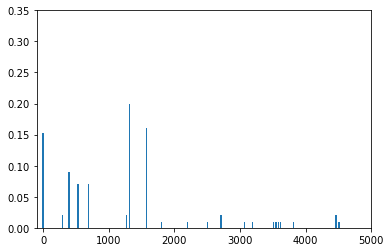

In [8]:
#spectrum in terms of energy
eng = np.array([omegaprim @ wo.Num2sth(xi[0], N, M, 'R') for xi in x])
plt.bar(eng,x[:,1],width = 20)
plt.axis([-100, 5000, 0,0.350])
ax = plt.gca()
ax.set_autoscale_on(False)
plt.show()

QAOA

In [8]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [9]:
def compute_hamiltonian(all_pat,y):

    H = 0

    for p,yi in zip(all_pat,y):
        
        if yi[0,0]==0:
            continue

        ops = []
        for t in p:
            if t == [0,1]:
                coefs = [1/2,-1/2]
            elif t == [1,0]:
                coefs = [1/2,1/2]
            else:
                coefs = [1,0]
            ops.append(SparsePauliOp(["I","Z"],coefs))
        op = ops[0]

        for i in range(1,len(ops)):
            op = op.tensor(ops[i]).simplify()
        H = (H + (op * yi[0,0])).simplify()

    H = H.simplify(atol=0.2, rtol=0)
    return np.real_if_close(H.coeffs),H.paulis


In [10]:
def find_col(spins_coordinates,y):
    uplet_ind = np.zeros((nn, M - nn + 1))
    for hh in range(nn): 
        uplet_ind[hh,:] = spins_coordinates[hh : M - nn + 1 + hh]
    ind_val = np.meshgrid(np.ones(M - nn + 1), N**np.arange(nn))[1][::-1]

    non_zero_elements = (np.sum(ind_val * uplet_ind, axis = 0) + (N**nn) * np.arange(M - nn + 1)).astype(int)

    At = np.zeros(len(y)).astype(int)
    At[non_zero_elements] = 1

    return At

In [11]:
def paulis_to_gates(pauli_string):
    return [i for i,s in enumerate(pauli_string) if s=='Z']


def obj_func(z):
    return (find_col(list(z),y)*y)[0,0]


def compute_expectation(counts):
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = -obj_func(bitstring)
        avg += obj * count
        sum_count += count
    print(avg/sum_count)
    return avg/sum_count

def create_qaoa_circ(theta,paulis_idx,H):

    nqubits = M
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

        for pstring,coef in zip(paulis_idx,H):
            if coef!=0:
                idx = paulis_to_gates(str(pstring))
                if len(idx)==1:
                    qc.rz(2*gamma[irep]*coef,idx[0])
                elif len(idx)==2:
                    qc.rzz(2*gamma[irep]*coef,idx[0],idx[1])
                elif len(idx)==3:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.rz(2*gamma[irep]*coef,idx[2])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])
                elif len(idx)==4:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[2],idx[3])
                    qc.rz(2*gamma[irep]*coef,idx[3])
                    qc.cnot(idx[2],idx[3])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])

    qc.measure_all()
    
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(paulis_idx,H,shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta,paulis_idx,H)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

In [12]:
#pattern of the form ai = (1 0)@(0 1)@(1 1)@....
#recover pattern and compute the hamiltonian H = Sum yi*ai
#QAOA

all_pat = []
for s in spins:
    all_pat += create_specific_patterns(s[0]-1,s[1]-1,M)

y= np.matrix(y).T if len(y.shape)==1 else y
H,paulis_idx = compute_hamiltonian(all_pat,y)
H

array([5.19916956, 0.41531433, 0.21081301, 0.20683626, 0.42329715,
       0.20763403, 0.42266349, 0.21129724, 0.42108862, 0.21019697,
       0.41242852, 0.2051106 , 0.39239546, 0.40698596, 0.41890238,
       0.20813109, 0.42160441, 0.20855262, 0.42144625, 0.21014287,
       0.34758674, 0.30648405, 0.40579099, 0.42215786, 0.20321909,
       0.41654485, 0.20771109, 0.39097402, 0.40040984, 0.23456738,
       0.41225709, 0.22300548, 0.35663409, 0.20086153])

In [28]:
expectation = get_expectation(H=H,paulis_idx=paulis_idx)

res = minimize(expectation,x0=np.ones(6),method='COBYLA')
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x,H=H,paulis_idx=paulis_idx)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

z = list(counts.keys())[np.argmax(list(counts.values()))]
v = BitArray(bin='0'+z).int
print(v)

# plot_histogram(counts)

-6.494043491068534
-6.494043491068534
